In [35]:
import numpy as np
import tensorflow as tf
import sys

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
sys.path.insert(0,'../')
from scripts.FlowVAEnet import FlowVAEnet
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm, convert_to_linear_norm

## Load images

In [37]:
bands = [4,5,6,7,8,9]

######## List of data samples
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d) if not f.endswith("metadata.npy")]

datalist = listdir_fullpath("/sps/lsst/users/bbiswas/simulations/COSMOS_btk/")

train_path = datalist[:800]
validation_path = datalist[800:]

# Take 1000 images from the first file.
images = np.load(validation_path[0], allow_pickle=True)

normalization_weights_path = '/sps/lsst/users/barcelin/data/blended_galaxies/' + '27.5/centered/test' 
print("Shape of loaded image" + str(np.shape(images)))

Shape of loaded image(484,)


## Convernt image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [38]:
from debvader.normalize import LinearNormCosmos

In [39]:
isolated_images = images['isolated_gal_stamps']

Text(0.5, 1.0, 'difference')

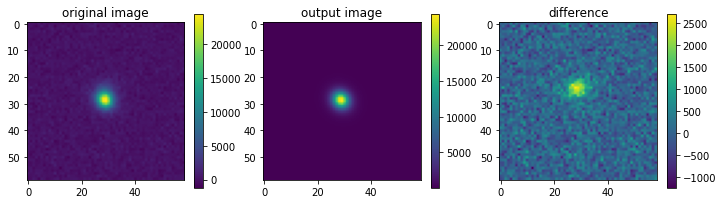

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

image_num = 5

im = axs[0].imshow(images['blended_gal_stamps'][image_num][2, :, :])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("original image")

im = axs[1].imshow(images['isolated_gal_stamps'][image_num][2, :, :])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("output image")


difference = images['blended_gal_stamps'][image_num][2, :, :] - images['isolated_gal_stamps'][image_num][2, :, :]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("difference")

In [41]:
images_isolated_normed = LinearNormCosmos().forward(np.array(np.array(images['isolated_gal_stamps'].tolist())))
images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = LinearNormCosmos().forward(np.array(np.array(images['blended_gal_stamps'].tolist())))
images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

## Load trained models

In [45]:
flow_net = FlowVAEnet(latent_dim=10, linear_norm=True)
flow_net.load_flow_weights(weights_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/updated_cosmos8dim/fvae/')
flow_net.load_vae_weights(weights_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/updated_cosmos8dim/vae/val_loss/')
print(flow_net.vae_model.summary())

in cropping
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 59, 59, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 65)                5709881   
_________________________________________________________________
multivariate_normal_tri_l_8  ((None, 10), (None, 10))  0         
_________________________________________________________________
decoder (Functional)         (None, 59, 59, 6)         3316044   
Total params: 9,025,925
Trainable params: 9,025,913
Non-trainable params: 12
_________________________________________________________________
None


## Test if VAE works

### Looking at image reconstruction

In [9]:
model_vae_output_isolated = flow_net.vae_model(images_isolated_normed)

2022-03-14 14:30:17.686319: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 215654912 exceeds 10% of free system memory.
2022-03-14 14:30:19.984810: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 215654912 exceeds 10% of free system memory.
2022-03-14 14:30:22.516193: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 215654912 exceeds 10% of free system memory.


KeyboardInterrupt: 

NameError: name 'model_vae_output_isolated' is not defined

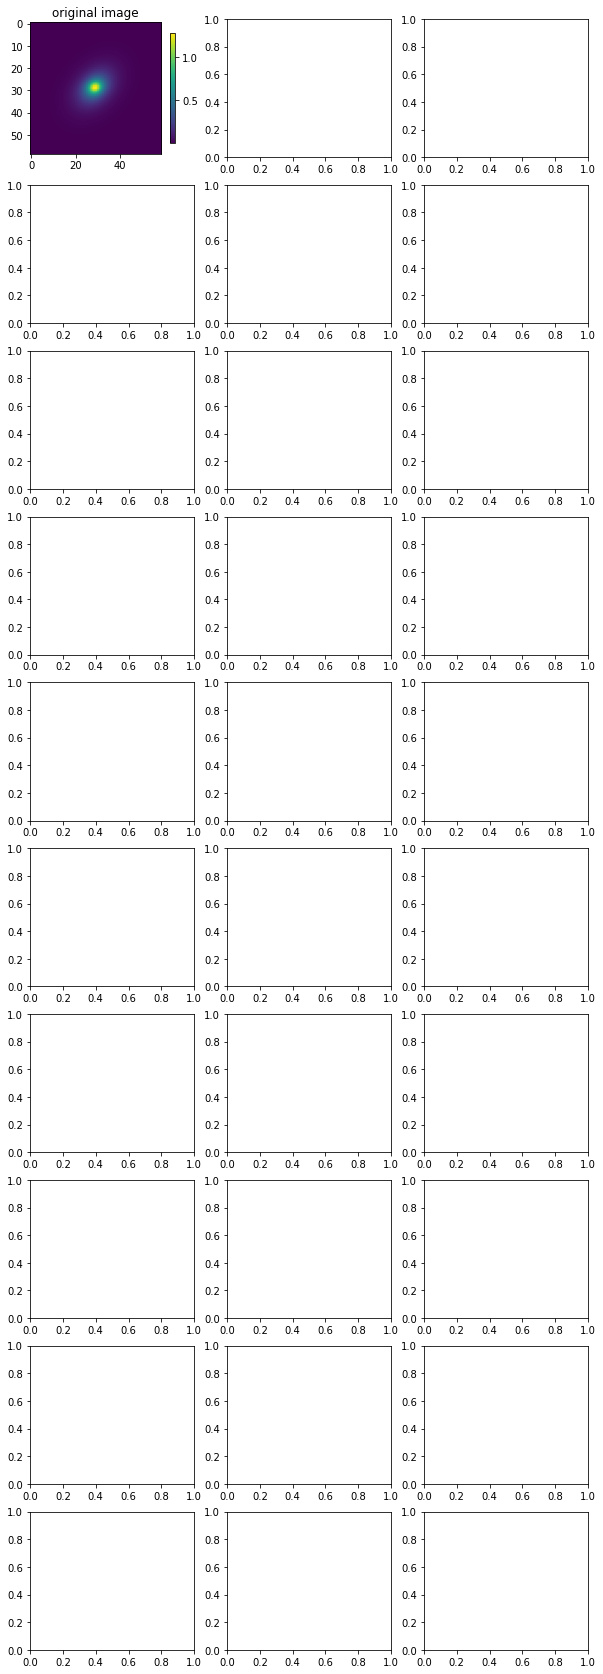

In [46]:
fig, axs = plt.subplots(10, 3, figsize=(10,30))

for i in range(10):
    image_num = i
    im = axs[i, 0].imshow(images_isolated_normed[image_num][:, :, 2])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated[0].mean().numpy()[image_num][ :, :, 2])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("output image")


    difference = images_isolated_normed[image_num][:, :, 2] - model_vae_output_isolated[0].mean().numpy()[image_num][ :, :, 2]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

In [ ]:
import tensorflow_probability as tfp
z = tfp.layers.MultivariateNormalTriL(event_size=10)(flow_net.encoder(images_isolated_normed))

In [ ]:
z.sample()

In [ ]:
z.covariance()

## Test if flow network works

The likelihood should be higher for isolated galaxies:

In [47]:
isolated_likelihood = flow_net.flow_model(images_isolated_normed)
noisy_likelihood = flow_net.flow_model(images_blended_normed)

likelihood_difference=isolated_likelihood-noisy_likelihood


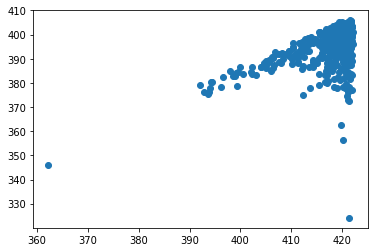

In [48]:
plt.scatter(isolated_likelihood, noisy_likelihood)

(array([ 35., 121.,  97.,  66.,  64.,  28.,  25.,  14.,  14.,   7.,   5.,
          3.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([12.929169, 15.741156, 18.553143, 21.365131, 24.177118, 26.989105,
        29.801092, 32.61308 , 35.425068, 38.237053, 41.04904 , 43.86103 ,
        46.673016, 49.485004, 52.29699 , 55.10898 , 57.920967, 60.732952,
        63.54494 , 66.356926, 69.168915, 71.9809  , 74.79289 , 77.60487 ,
        80.41686 , 83.22885 , 86.04084 , 88.85283 , 91.66481 , 94.4768  ,
        97.28879 ], dtype=float32),
 <BarContainer object of 30 artists>)

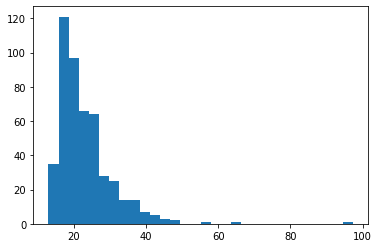

In [49]:
plt.hist(likelihood_difference.numpy(), bins=30)

This plot shows that we always observe the log prob of isolated galaxies to be higher than that of noisy/blended ones